# Create Train/Dev/Test sets using AotM-2011 Playlists & MSD Audio Features

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import lil_matrix, issparse

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data/aotm-2011'
faotm = os.path.join(data_dir, 'aotm2011-subset.pkl')
ffeature = 'data/msd/songID2Features.pkl'

In [3]:
fx      = os.path.join(data_dir, 'X_audio.pkl')
fy      = os.path.join(data_dir, 'Y_audio.pkl')
fxtrain = os.path.join(data_dir, 'X_train_audio.pkl')
fytrain = os.path.join(data_dir, 'Y_train_audio.pkl')
fxdev   = os.path.join(data_dir, 'X_dev_audio.pkl')
fydev   = os.path.join(data_dir, 'Y_dev_audio.pkl')
fxtest  = os.path.join(data_dir, 'X_test_audio.pkl')
fytest  = os.path.join(data_dir, 'Y_test_audio.pkl')

## Data loading

Load playlists.

In [4]:
playlists = pkl.load(open(faotm, 'rb'))

In [5]:
print('#Playlists: %d' % len(playlists))

#Playlists: 95298


In [6]:
playlists[0]

['SOFDPDC12A58A7D198',
 'SOPIEQP12A8C13F268',
 'SOKMCJK12A6D4F6105',
 'SOGTGJR12A6310E08D',
 'SOLTBYJ12A6310F2BB',
 'SOBOXXN12A6D4FA1A2',
 'SOUQUFO12B0B80778E']

In [7]:
#print('#Songs: %d' % len({songID for p in playlists for songID in p['filtered_lists'][0]}))

Average playlist length: 9.4


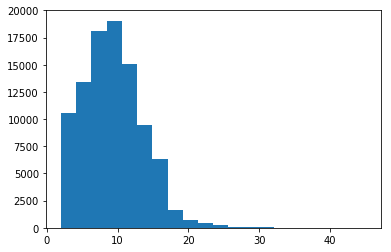

In [8]:
#lengths = [len(p['filtered_lists'][0]) for p in playlists]
lengths = [len(sl) for sl in playlists]
plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [9]:
song2Features = pkl.load(open(ffeature, 'rb'))

The set of songs, which is the set of labels in this formulation.

In [10]:
#song_set = sorted(song2Features.keys())  # use MSD songs as label space
song_set = sorted({sid for pl in playlists for sid in pl})   # use the intersection of MSD and AotM as label space

In [11]:
len(song_set)

119466

In [12]:
label_indices = {songID: ix for ix, songID in enumerate(song_set)}

In [13]:
list(label_indices.items())[:10]

[('SOAAAFI12A6D4F9C66', 0),
 ('SOAAAMT12AB018C9C4', 1),
 ('SOAAASR12AB018A516', 2),
 ('SOAABHX12AAF3B40E7', 3),
 ('SOAABLG12A6D4F73D2', 4),
 ('SOAABMP12A6D4F7633', 5),
 ('SOAABMR12A6D4F70E4', 6),
 ('SOAABQL12A67020E76', 7),
 ('SOAABRB12A58A792A3', 8),
 ('SOAACBE12A6D4F7A54', 9)]

In [14]:
def gen_training_set(playlists, label_indices, features):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - playlists: which playlists to create features for
            - label_indices: a dictionary that maps a songID to the index of the corresponding label
            - features: a dictionary that maps a songID to its feature vector
            
        Output:
            - (Feature, Label) pair (X, Y), with # num playlists rows
              X comprises the features for each seed song
              Y comprises the indicators of whether the given song is present in the respective playlist
    """

    N = len(playlists)
    K = len(label_indices)

    X = [ ]
    Y = lil_matrix((N, K), dtype=np.int8)
    
    cnt = 0
    for i in range(len(playlists)):
        cnt += 1
        if cnt % 1000 == 0:
            sys.stdout.write('\r%d / %d' % (cnt, len(playlists)))
            sys.stdout.flush()
            
        playlist = playlists[i]
        seed     = playlist[0]

        X.append(features[seed])
        #indices = [label_indices[s] for s in playlist]
        indices = [label_indices[s] for s in playlist if s in label_indices]
        Y[i, indices] = 1

    return np.array(X), Y.tocsr()

In [15]:
#test_dict = {1: 0, 2: 1, 3: 2}
#[test_dict[s] for s in [1, 2, 5] if s in test_dict]

## Training & Test

Train a logistic regression model for each label.

In [16]:
if np.all([os.path.exists(fname) for fname in [fxtrain, fytrain, fxdev, fydev, fxtest, fytest]]):
    X_train = pkl.load(open(fxtrain, 'rb'))
    Y_train = pkl.load(open(fytrain, 'rb'))
    X_dev   = pkl.load(open(fxdev,   'rb'))
    Y_dev   = pkl.load(open(fydev,   'rb'))
    X_test  = pkl.load(open(fxtest,  'rb'))
    Y_test  = pkl.load(open(fytest,  'rb'))
else:
    # generate dataset
    X, Y = gen_training_set(playlists=playlists, label_indices=label_indices, features=song2Features)
    
    # data split: approximately 70/10/20 for training/dev/test
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_other, Y_train, Y_other = train_test_split(X, Y, test_size=0.3, random_state=31)
    X_dev,   X_test,  Y_dev,   Y_test  = train_test_split(X_other, Y_other, test_size=0.65, random_state=59)
    
    # feature normalisation
    X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
    X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-8)
    X_train -= X_train_mean
    X_train /= X_train_std
    X_dev   -= X_train_mean
    X_dev   /= X_train_std
    X_test  -= X_train_mean
    X_test  /= X_train_std
    
    # save to files
    pkl.dump(X,       open(fx,      'wb'))
    pkl.dump(Y,       open(fy,      'wb'))
    pkl.dump(X_train, open(fxtrain, 'wb'))
    pkl.dump(Y_train, open(fytrain, 'wb'))
    pkl.dump(X_dev,   open(fxdev,   'wb'))
    pkl.dump(Y_dev,   open(fydev,   'wb'))
    pkl.dump(X_test,  open(fxtest,  'wb'))
    pkl.dump(Y_test,  open(fytest,  'wb'))

95000 / 95298

In [17]:
print('Train: %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev  : %15s %15s' % (X_dev.shape,   Y_dev.shape))
print('Test : %15s %15s' % (X_test.shape,  Y_test.shape))

Train:     (66708, 91) (66708, 119466)
Dev  :     (10006, 91) (10006, 119466)
Test :     (18584, 91) (18584, 119466)
